In [6]:
import json
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull

# Load the scaler parameters from JSON
with open('/Users/justint/Library/CloudStorage/OneDrive-Personal/Desktop/Academic Stuff/Arias Research/Materials_NN/Paper_Materials_2025/training/batch_3/scaler_y_0_025eV.json', 'r') as f:
    scaler_params = json.load(f)

# Create a new MinMaxScaler instance and set its parameters
scaler_y = MinMaxScaler(feature_range=tuple(scaler_params['feature_range']))
scaler_y.min_ = np.array(scaler_params['min_'])
scaler_y.scale_ = np.array(scaler_params['scale_'])
scaler_y.data_min_ = np.array(scaler_params['data_min_'])
scaler_y.data_max_ = np.array(scaler_params['data_max_'])
scaler_y.data_range_ = np.array(scaler_params['data_range_'])

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

class DeepSet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(DeepSet, self).__init__()
        self.rho = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            # nn.Linear(hidden_dim, hidden_dim),
            # nn.Tanh(),
            # nn.Linear(hidden_dim, hidden_dim),
            # nn.Tanh(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        output = self.rho(x)
        return output

class InverseScaler(nn.Module):
    def __init__(self, feature_range, data_min, data_range):
        super(InverseScaler, self).__init__()
        feature_min, feature_max = feature_range
        self.a = data_range / (feature_max - feature_min)
        self.b = (-feature_min * self.a) + data_min
        # Convert to tensors and register as buffers
        self.register_buffer('a_tensor', torch.tensor(self.a, dtype=torch.float32))
        self.register_buffer('b_tensor', torch.tensor(self.b, dtype=torch.float32))
    
    def forward(self, x):
        return x * self.a_tensor + self.b_tensor

class DeepSetWithInverseScaling(nn.Module):
    def __init__(self, original_model, scaler_params):
        super(DeepSetWithInverseScaling, self).__init__()
        self.original_model = original_model
        feature_range = scaler_params['feature_range']
        data_min = scaler_params['data_min_'][0]
        data_range = scaler_params['data_range_'][0]
        self.inverse_scaler = InverseScaler(feature_range, data_min, data_range)
    
    def forward(self, x):
        scaled_output = self.original_model(x)
        inverse_scaled_output = self.inverse_scaler(scaled_output)
        return inverse_scaled_output

# Load OH_elements and p_dict_oh as in your original code
with open('/Users/justint/Library/CloudStorage/OneDrive-Personal/Desktop/Academic Stuff/Arias Research/Materials_NN/Paper_Materials_2025/training/OH_elements.json', 'r') as file:
    OH_elements = json.load(file)

total_N_elements = len(OH_elements)

with open('/Users/justint/Library/CloudStorage/OneDrive-Personal/Desktop/Academic Stuff/Arias Research/Materials_NN/Paper_Materials_2025/training/p_dict_oh.json', 'r') as file:
    p_dict_oh = json.load(file)

# Parameters
input_dim = len(p_dict_oh['H'])  # Dimension of each feature vector
hidden_dim = 16  # Hidden layer size
output_dim = 1  # Single value output (formation energy)

# Initialize the original model and load state
model = DeepSet(input_dim, hidden_dim, output_dim).to(device)
model_path = '/Users/justint/Library/CloudStorage/OneDrive-Personal/Desktop/Academic Stuff/Arias Research/Materials_NN/Paper_Materials_2025/training/batch_3/model_relu_wd_1e-12_1layer16_0_025eV_convex.pth'
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

def pred_energy(el1, el2, el3, s1, s2, s3):
    ps = []
    sum_stoichs = s1 + s2 + s3
    ps.append(float(s1 / sum_stoichs) * np.array(p_dict_oh[el1]))
    ps.append(float(s2 / sum_stoichs) * np.array(p_dict_oh[el2]))
    ps.append(float(s3 / sum_stoichs) * np.array(p_dict_oh[el3]))

    feature_0 = []
    for i in range(len(ps)):
        feature_0.append(ps[i])
    for i in range(len(ps), 5):
        feature_0.append(np.zeros(len(OH_elements)))
    feature_0_np = np.array(feature_0)
    feature0_tensor = torch.tensor(feature_0_np, dtype=torch.float32).to(device)
    feature0_tensor = feature0_tensor.unsqueeze(0)  # Add batch and channel dimensions
    predicted_en = model(feature0_tensor)
    predicted_en_inv = scaler_y.inverse_transform(predicted_en.detach().cpu().numpy().reshape(-1, 1))
    return predicted_en_inv

energies = []
species_data = []
OH_coeffs = np.linspace(0.0, 2, 12)
k = 1
for i in OH_coeffs:
    for j in range(1):
        energy_per_atom = pred_energy('Ti', 'O', 'H', 1, i, j)[0]
        if i == 0 and j == 0:
            species_data.append({
                'name': 'Ti',
                'formula_str': 'Ti',
                'phase': 'solid',
                'Ef': energy_per_atom * (1+i+j)
            })
        elif i == 0:
            species_data.append({
                'name': f'TiH$_{{{j:.2f}}}$',  # Format the j coefficient correctly
                'formula_str': f'TiH{j}',
                'phase': 'solid',
                'Ef': energy_per_atom * (1+i+j)
            })  
        elif j == 0:
            species_data.append({
                'name': f'TiO$_{{{i:.2f}}}$',  # Format the i coefficient correctly
                'formula_str': f'TiO{i}',
                'phase': 'solid',
                'Ef': energy_per_atom * (1+i+j)
            }) 
        else:
            species_data.append({
                'name': f'TiO$_{{{i:.2f}}}$H$_{{{j:.2f}}}$',  # Both i and j coefficients
                'formula_str': f'TiO{i}H{j}',
                'phase': 'solid',
                'Ef': energy_per_atom * (1+i+j)
            })
        print(f'Iteration {k}: TiO{i}H{j}, Ef={energy_per_atom * (1+i+j)} eV/fu')
        k += 1




# shift all energies 

Ef_TiO = pred_energy('Ti', 'O', 'H', 1, 1, 0)[0] * (1+1)
Ef_TiO2 = pred_energy('Ti', 'O', 'H', 1, 2, 0)[0] * (1+2)

# compute bias shift corresponding to experimental formation energies
bias = 1/2 * (Ef_TiO2+9.211 + Ef_TiO+5.072)

species_data_ionic = [
    # Ionic species
    {
        'name': 'Ti$^{2+}$',
        'formula_str': 'Ti',
        'phase': 'ion',
        'charge': +2,
        'Ef': -3.257 + bias  # eV/fu
    },
    {
        'name': 'Ti$^{3+}$',
        'formula_str': 'Ti',
        'phase': 'ion',
        'charge': +3,
        'Ef': -3.626 + bias
    },
    {
        'name': 'TiO$^{2+}$',
        'formula_str': 'TiO',
        'phase': 'ion',
        'charge': +2,
        'Ef': -4.843 + bias
    },
    {
        'name': 'TiHO$_3$$^{-}$',
        'formula_str': 'TiHO3',
        'phase': 'ion',
        'charge': -1,
        'Ef': -9.908 + bias
    },
    {
        'name': 'TiO$_2$$^{2+}$',
        'formula_str': 'TiO2',
        'phase': 'ion',
        'charge': +2,
        'Ef': -4.845 + bias
    }]

# append to species_data
for entry in species_data_ionic:
    species_data.append(entry)

Using device: cpu
Iteration 1: TiO0.0H0, Ef=[-0.02941186] eV/fu
Iteration 2: TiO0.18181818181818182H0, Ef=[-0.81594144] eV/fu
Iteration 3: TiO0.36363636363636365H0, Ef=[-1.60247066] eV/fu
Iteration 4: TiO0.5454545454545454H0, Ef=[-2.38900044] eV/fu
Iteration 5: TiO0.7272727272727273H0, Ef=[-3.17553041] eV/fu
Iteration 6: TiO0.9090909090909092H0, Ef=[-3.96205967] eV/fu
Iteration 7: TiO1.0909090909090908H0, Ef=[-4.74859144] eV/fu
Iteration 8: TiO1.2727272727272727H0, Ef=[-5.53512086] eV/fu
Iteration 9: TiO1.4545454545454546H0, Ef=[-6.29960775] eV/fu
Iteration 10: TiO1.6363636363636365H0, Ef=[-7.05982096] eV/fu
Iteration 11: TiO1.8181818181818183H0, Ef=[-7.82003689] eV/fu
Iteration 12: TiO2.0H0, Ef=[-8.58025217] eV/fu


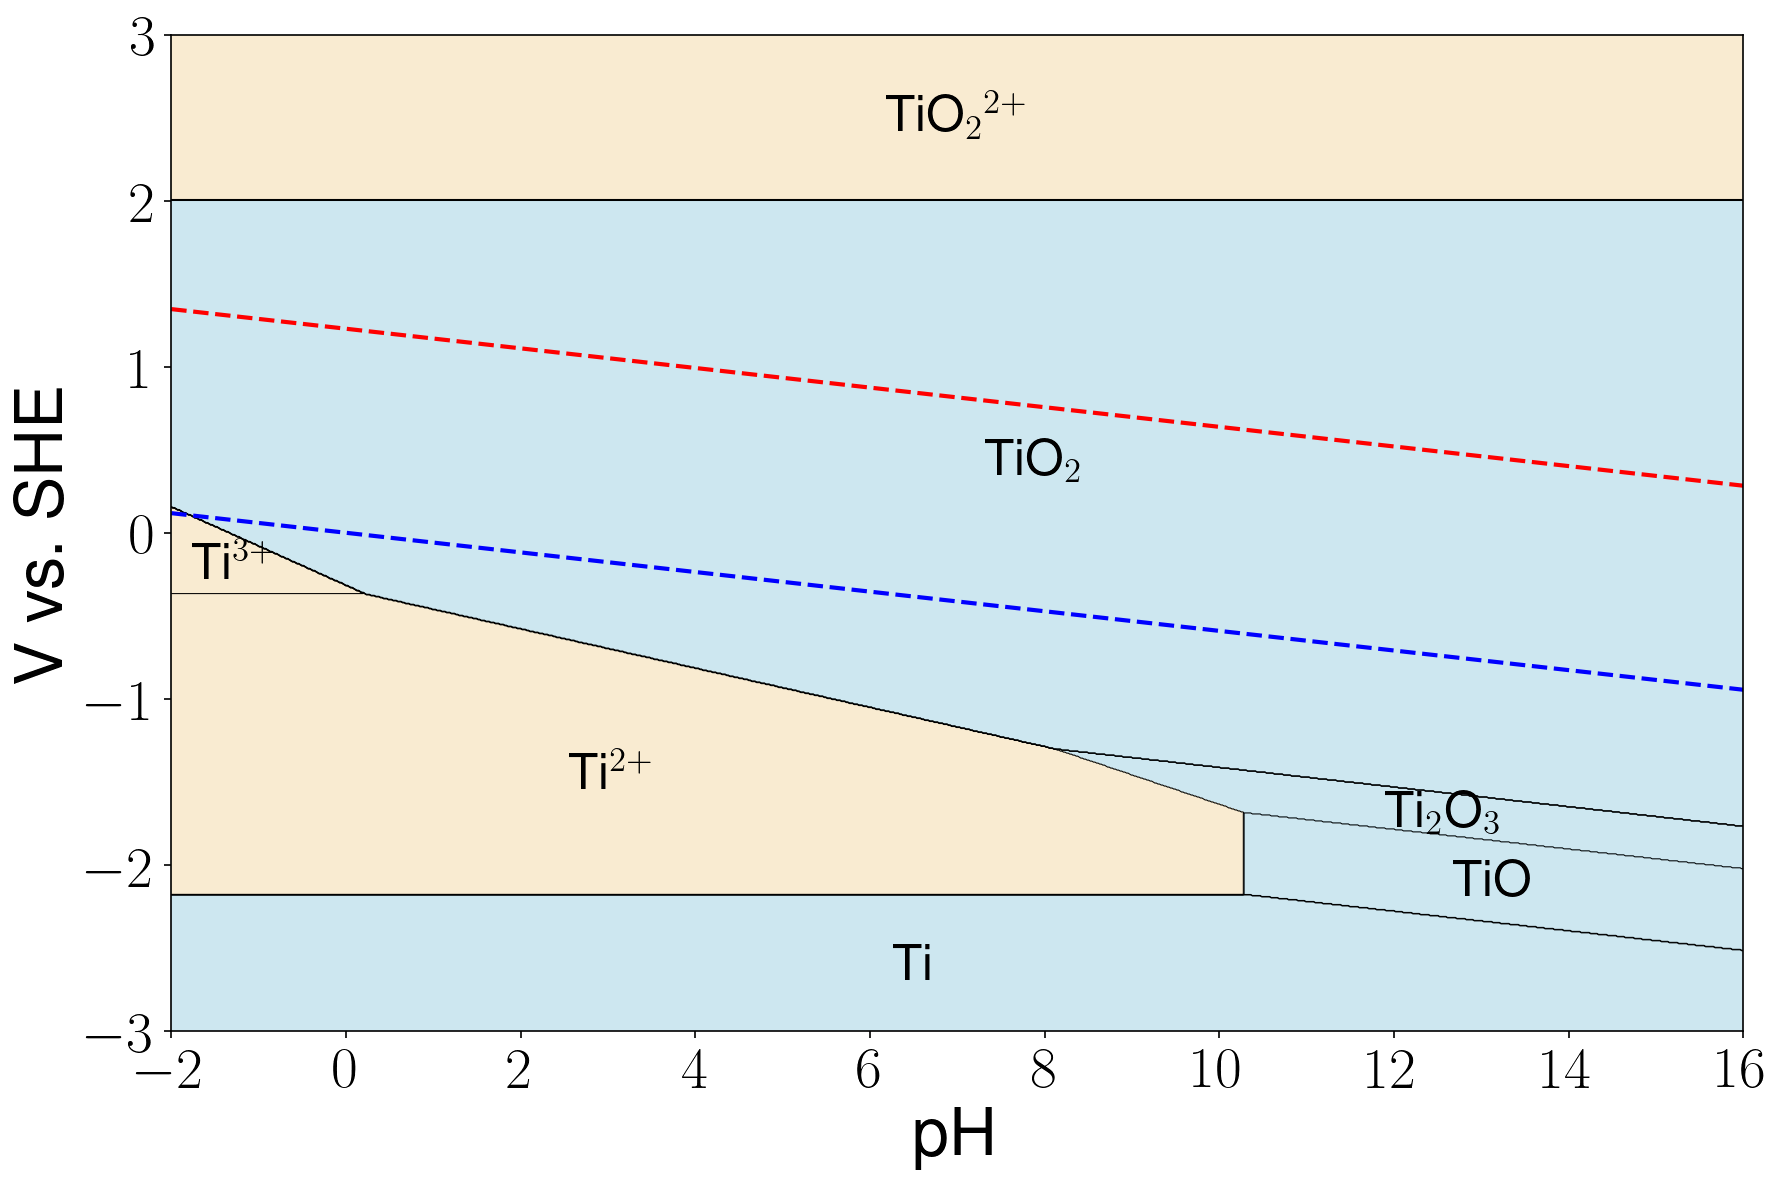

In [7]:
# Ti Pourbaix diagram

import numpy as np
import matplotlib.pyplot as plt
import re
import matplotlib.colors as mcolors
from matplotlib.patches import Patch

# Species data for materials project directly
bias = - 1/3 * (0.75 + 0.53 + 0.95)

species_data = [
    # Solid species
    {
        'name': 'Ti',
        'phase': 'solid',
        'Ef': 0.0  # eV/fu
    },
    {
        'name': 'TiO$_2$',
        'formula_str': 'TiO2',
        'phase': 'solid',
        'Ef': -3.32*3  # eV/fu
    },
    {
        'name': 'TiO',
        'formula_str': 'TiO',
        'phase': 'solid',
        'Ef': -2.80*2
    },
    {
        'name': 'Ti$_2$O$_3$',
        'formula_str': 'TiO1.5',
        'phase': 'solid',
        'Ef': -3.163*2.5
    },

    # Ionic species
    {
        'name': 'Ti$^{2+}$',
        'formula_str': 'Ti',
        'phase': 'ion',
        'charge': +2,
        'Ef': -3.257 + bias  # eV/fu
    },
    {
        'name': 'Ti$^{3+}$',
        'formula_str': 'Ti',
        'phase': 'ion',
        'charge': +3,
        'Ef': -3.626 + bias
    },
    {
        'name': 'TiO$^{2+}$',
        'formula_str': 'TiO',
        'phase': 'ion',
        'charge': +2,
        'Ef': -4.843 + bias
    },
    {
        'name': 'TiHO$_3$$^{-}$',
        'formula_str': 'TiHO3',
        'phase': 'ion',
        'charge': -1,
        'Ef': -9.908 + bias
    },
    {
        'name': 'TiO$_2$$^{2+}$',
        'formula_str': 'TiO2',
        'phase': 'ion',
        'charge': +2,
        'Ef': -4.845 + bias
    },
]

# Note: MUST ensure all solid/ion compounds have stoichiometry of Ti as one, since we are simulating the solvation of one unit of Ti!

# Constants
F = 96485.33212  # Faraday's constant, C/mol
R = 8.314462618  # Gas constant, J/(mol·K)
T = 298.15       # Temperature, K

# Create a grid of pH and E values
pH_range = np.linspace(-2, 16, 1000)
E_range = np.linspace(-3, 3, 1000)
pH_grid, E_grid = np.meshgrid(pH_range, E_range)

# Function to parse chemical formulas
def parse_formula(formula):
    # Updated regex pattern to capture decimal numbers
    pattern = r'([A-Z][a-z]*)(\d*\.?\d*)'
    tokens = re.findall(pattern, formula)
    formula_dict = {}
    for (element, count) in tokens:
        if count == '':
            count = 1.0  # Default to 1.0 for elements without a count
        else:
            count = float(count)  # Convert to float to handle decimal numbers
        formula_dict[element] = formula_dict.get(element, 0) + count
    return formula_dict

# Parse the formulas
for species in species_data:
    if 'formula_str' in species:
        species['formula'] = parse_formula(species['formula_str'])
    else:
        species['formula'] = parse_formula(species['name'])

# Function to calculate Gibbs free energy for each species at each point
def calculate_gibbs_energy(species, pH_grid, E_grid):
    y = species['formula'].get('O', 0)
    z = species['formula'].get('H', 0)
    delta_Gf = species['Ef']  # in eV/fu
    delta_Gf_H2O = -2.46      # in eV/fu
    if species['phase'] == 'solid':
        n = 2 * y - z
        if n == 0:  # indicates that pure solid Ti has been input
            return np.zeros_like(pH_grid)
        E_standard = -(y * delta_Gf_H2O - delta_Gf) / n
        E_calc = E_standard - 0.0591 * pH_grid
    elif species['phase'] == 'ion':
        c = species['charge']
        n = 2 * y + c - z
        if n == 0:
            return None
        E_standard = -(y * delta_Gf_H2O - delta_Gf) / n
        log_conc = np.log10(1e-6)  # Assuming 10^-6 M concentration
        E_calc = E_standard + (0.0591 / n) * (log_conc - (2 * y - z) * pH_grid)
    else:
        return None
    # Calculate Gibbs free energy at each point
    delta_G = n * (E_calc - E_grid)  # in J/mol
    return delta_G

# Calculate Gibbs free energy for each species
delta_G_species = []
for species in species_data:
    delta_G = calculate_gibbs_energy(species, pH_grid, E_grid)
    if delta_G is not None:
        delta_G_species.append({
            'name': species['name'],
            'delta_G': delta_G
        })

# Determine the most stable species at each point
delta_G_values = np.array([s['delta_G'] for s in delta_G_species])
stable_indices = np.argmin(delta_G_values, axis=0)

# Initialize stable species array
stable_species = np.empty_like(pH_grid, dtype=object)

# Assign the most stable species to each point in the grid
for i in range(stable_indices.shape[0]):
    for j in range(stable_indices.shape[1]):
        min_index = stable_indices[i, j]
        stable_species[i, j] = delta_G_species[min_index]['name']

# Map species names to integers for coloring
species_names = [s['name'] for s in species_data]
species_to_int = {name: idx for idx, name in enumerate(species_names)}
stable_species_int = np.vectorize(species_to_int.get)(stable_species)

# Get all oxygen values to normalize
oxygen_values = [species['formula'].get('O', 0) for species in species_data if species['phase'] == 'solid']

# Normalize oxygen values for colormap
norm = mcolors.Normalize(vmin=min(oxygen_values), vmax=max(oxygen_values))
colormap = plt.cm.Greens  # Use the 'Greens' colormap for varying green shades

species_colors = []
for species in species_data:
    if species['phase'] == 'solid':
        species_colors.append('#ADD8E6')  # Light blue
    elif species['phase'] == 'ion':
        # Ionic compounds (beige)
        species_colors.append('#F5DEB3')  # Wheat (beige)
    else:
        # Default color for other types, if any
        species_colors.append('#D3D3D3')  # Light gray

# Create a color map from these specific colors
cmap = mcolors.ListedColormap(species_colors)

# ── Global matplotlib style (LaTeX fonts, larger text) ──────────────
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica", "DejaVu Sans"],
    "font.weight": "bold",
    "axes.labelweight": "bold",
    "axes.labelsize": 32,
    "axes.titlesize": 38,
    "xtick.labelsize": 28,
    "ytick.labelsize": 28,
})

# create figure+axes with higher DPI for better resolution
fig, ax = plt.subplots(figsize=(12, 8), dpi=150)

# Plotting the Pourbaix diagram
cf = ax.contourf(
    pH_grid, E_grid, stable_species_int,
    levels=np.arange(len(species_names) + 1) - 0.5,
    cmap=cmap, alpha=0.6
)
# boundaries
ax.contour(
    pH_grid, E_grid, stable_species_int,
    levels=np.arange(len(species_names) + 1) - 0.5,
    colors='black', linewidths=0.5
)

# find & plot centers of mass
CM = []
for i, name in enumerate(species_names):
    mask = (stable_indices == i)
    y_idx, x_idx = np.where(mask)
    if len(x_idx):
        mean_pH = pH_range[int(np.mean(x_idx))]
        mean_E  = E_range[int(np.mean(y_idx))]
        CM.append((name, mean_pH, mean_E))

for name, mpH, mE in CM:
    ax.text(mpH, mE, name, ha='center', va='center', fontsize=24)

# water stability lines
ax.plot(pH_range, 1.229 - 0.0591 * pH_range, "--", lw=2, color="red", label=r"$\mathrm{O_2/H_2O}$")
ax.plot(pH_range,       - 0.0591 * pH_range, "--", lw=2, color="blue", label=r"$\mathrm{H^+/H_2}$")

# axes limits & ticks
ax.set_xlim(-2, 14)
ax.set_xticks(np.arange(-2, 17, 2))
ax.set_ylim(-3, 3)
ax.set_xlabel(r"pH")
ax.set_ylabel(r"V vs.\ SHE")


plt.tight_layout()
plt.show()

/var/folders/yl/sv3dx7zs13s3phj74920ys6w0000gn/T/ipykernel_16663/2442900205.py:228: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot(pH_range, E_O2, 'k--', label='O$_2$/H$_2$O', color='red')
/var/folders/yl/sv3dx7zs13s3phj74920ys6w0000gn/T/ipykernel_16663/2442900205.py:229: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot(pH_range, E_H2, 'k--', label='H$^+$/H$_2$', color='red')


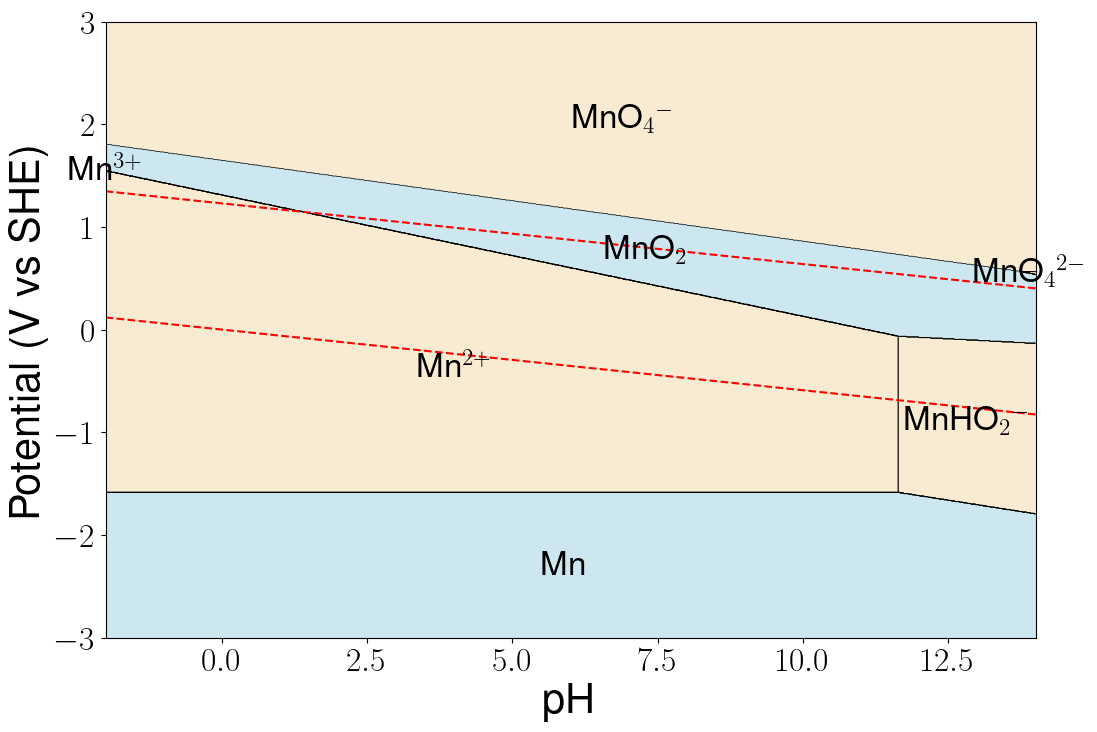

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import re
import matplotlib.colors as mcolors
from matplotlib.patches import Patch

# Mn Pourbaix diagram

# Biases: Materials Project minus Experimental formation energy (eV/fu)
bias = -3.958 + 3.528

# Ion database of experimental free energies plus Materials Project bias (eV/fu)

species_data = [
    {
        'name': 'Mn$^{2+}$',
        'formula_str': 'Mn',
        'phase': 'ion',
        'charge': +2,
        'Ef': -2.387 + bias
    },
    {
        'name': 'MnO$_4$$^{2-}$',
        'formula_str': 'MnO4',
        'phase': 'ion',
        'charge': -2,
        'Ef': -5.222 + bias
    },
    {
        'name': 'MnHO$_2$$^{-}$',
        'formula_str': 'MnHO2',
        'phase': 'ion',
        'charge': -1,
        'Ef': -5.243 + bias
    },
    {
        'name': 'Mn$^{3+}$',
        'formula_str': 'Mn',
        'phase': 'ion',
        'charge': +3,
        'Ef': -0.850 + bias
    },  
    {
        'name': 'MnO$_4$$^{-}$',
        'formula_str': 'MnO4',
        'phase': 'ion',
        'charge': -1,
        'Ef': -4.658 + bias
    },

    # solid
    {
        'name': 'MnO$_2$',
        'formula_str': 'MnO2',
        'phase': 'solid',
        'charge': 0,
        'Ef': 3 * (-1.823)
    },
    # {
    #     'name': 'Mn$_2$O$_3$',
    #     'formula_str': 'Mn2O3',
    #     'phase': 'solid',
    #     'charge': 0,
    #     'Ef': 5 * (-2.014)
    # },
    {
        'name': 'Mn',
        'formula_str': 'Mn',
        'phase': 'solid',
        'charge': 0,
        'Ef': 0
    }
]

# Note: MUST ensure all solid/ion compounds have stoichiometry of Ti as one, since we are simulating the solvation of one unit of Ti!

# Constants
F = 96485.33212  # Faraday's constant, C/mol
R = 8.314462618  # Gas constant, J/(mol·K)
T = 298.15       # Temperature, K

# Create a grid of pH and E values
pH_range = np.linspace(-2, 14, 1000)
E_range = np.linspace(-3, 3, 1000)
pH_grid, E_grid = np.meshgrid(pH_range, E_range)

# Function to parse chemical formulas
def parse_formula(formula):
    # Updated regex pattern to capture decimal numbers
    pattern = r'([A-Z][a-z]*)(\d*\.?\d*)'
    tokens = re.findall(pattern, formula)
    formula_dict = {}
    for (element, count) in tokens:
        if count == '':
            count = 1.0  # Default to 1.0 for elements without a count
        else:
            count = float(count)  # Convert to float to handle decimal numbers
        formula_dict[element] = formula_dict.get(element, 0) + count
    return formula_dict

# Parse the formulas
for species in species_data:
    if 'formula_str' in species:
        species['formula'] = parse_formula(species['formula_str'])
    else:
        species['formula'] = parse_formula(species['name'])

# Function to calculate Gibbs free energy for each species at each point
def calculate_gibbs_energy(species, pH_grid, E_grid):
    y = species['formula'].get('O', 0)
    z = species['formula'].get('H', 0)
    delta_Gf = species['Ef']  # in eV/fu
    delta_Gf_H2O = -2.46      # in eV/fu
    if species['phase'] == 'solid':
        n = 2 * y - z
        if n == 0:  # indicates that pure solid Ti has been input
            return np.zeros_like(pH_grid)
        E_standard = -(y * delta_Gf_H2O - delta_Gf) / n
        E_calc = E_standard - 0.0591 * pH_grid
    elif species['phase'] == 'ion':
        c = species['charge']
        n = 2 * y + c - z
        if n == 0:
            return None
        E_standard = -(y * delta_Gf_H2O - delta_Gf) / n
        log_conc = np.log10(1e-6)  # Assuming 10^-6 M concentration
        E_calc = E_standard + (0.0591 / n) * (log_conc - (2 * y - z) * pH_grid)
    else:
        return None
    # Calculate Gibbs free energy at each point
    delta_G = n * (E_calc - E_grid)  # in J/mol
    return delta_G

# Calculate Gibbs free energy for each species
delta_G_species = []
for species in species_data:
    delta_G = calculate_gibbs_energy(species, pH_grid, E_grid)
    if delta_G is not None:
        delta_G_species.append({
            'name': species['name'],
            'delta_G': delta_G
        })

# Determine the most stable species at each point
delta_G_values = np.array([s['delta_G'] for s in delta_G_species])
stable_indices = np.argmin(delta_G_values, axis=0)

# Initialize stable species array
stable_species = np.empty_like(pH_grid, dtype=object)

# Assign the most stable species to each point in the grid
for i in range(stable_indices.shape[0]):
    for j in range(stable_indices.shape[1]):
        min_index = stable_indices[i, j]
        stable_species[i, j] = delta_G_species[min_index]['name']

# Map species names to integers for coloring
species_names = [s['name'] for s in species_data]
species_to_int = {name: idx for idx, name in enumerate(species_names)}
stable_species_int = np.vectorize(species_to_int.get)(stable_species)

# Get all oxygen values to normalize
oxygen_values = [species['formula'].get('O', 0) for species in species_data if species['phase'] == 'solid']

# Normalize oxygen values for colormap
norm = mcolors.Normalize(vmin=min(oxygen_values), vmax=max(oxygen_values))
colormap = plt.cm.Greens  # Use the 'Greens' colormap for varying green shades

species_colors = []
for species in species_data:
    if species['phase'] == 'solid':
        species_colors.append('#ADD8E6')  # Light blue
    elif species['phase'] == 'ion':
        # Ionic compounds (beige)
        species_colors.append('#F5DEB3')  # Wheat (beige)
    else:
        # Default color for other types, if any
        species_colors.append('#D3D3D3')  # Light gray

# Create a color map from these specific colors
cmap = mcolors.ListedColormap(species_colors)

# Plotting the Pourbaix diagram
plt.figure(figsize=(12, 8))
plt.contourf(pH_grid, E_grid, stable_species_int, levels=np.arange(len(species_names) + 1) - 0.5, cmap=cmap, alpha=0.6)

# Plot boundaries between regions with different species
plt.contour(pH_grid, E_grid, stable_species_int, levels=np.arange(len(species_names) + 1) - 0.5, colors='black', linewidths=0.5)

# Find center of masses of stable regions
CM = []
for i in range(len(species_data)):
    try:
        val = i  # The integer value whose center of mass you want to find

        # Step 1: Create a mask where arr == val
        mask = (stable_indices == val)

        # Step 2: Get the indices where arr == val
        y_indices, x_indices = np.where(mask)

        # Step 3: Compute the mean x and y indices (no integer rounding)
        mean_x = np.mean(x_indices)
        mean_y = np.mean(y_indices)

        # Convert grid indices back to pH and E coordinates
        mean_pH = pH_range[int(mean_x)]
        mean_E = E_range[int(mean_y)]

        CM.append({
            'name': species_names[i],
            'mean_pH': mean_pH,
            'mean_E': mean_E
            })
    except:
        pass

# Plot the names at the centers of mass
for material in CM:
    name = material['name']
    mean_pH = material['mean_pH']
    mean_E = material['mean_E']
    plt.text(mean_pH, mean_E, name, ha='center', va='center', fontsize=24, color='black')

# Plot water stability lines
E_O2 = 1.229 - (0.0591) * pH_range  # O2/H2O line (assuming 4e- transfer)
E_H2 = 0 - (0.0591) * pH_range      # H+/H2 line (assuming 2e- transfer)
plt.plot(pH_range, E_O2, 'k--', label='O$_2$/H$_2$O', color='red')
plt.plot(pH_range, E_H2, 'k--', label='H$^+$/H$_2$', color='red')

# Set plot limits and labels
plt.xlim(-2, 14)
plt.ylim(-3, 3)
plt.xlabel('pH', fontsize=30)
plt.ylabel('Potential (V vs SHE)', fontsize=30)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)

# Create a custom legend for the plot
legend_elements = [Patch(facecolor=species_colors[i], label=species_names[i]) for i in range(len(species_names))]
# plt.legend(handles=legend_elements + [plt.Line2D([], [], linestyle='--', color='k', label='Water Stability Lines')], fontsize=10, loc='upper right')

plt.show()


/Users/justint/Library/Python/3.9/lib/python/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/justint/Library/Python/3.9/lib/python/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/yl/sv3dx7zs13s3phj74920ys6w0000gn/T/ipykernel_14927/3902576456.py:210: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot(pH_range, E_O2, 'k--', label='O$_2$/H$_2$O', color='red')
/var/folders/yl/sv3dx7zs13s3phj74920ys6w0000gn/T/ipykernel_14927/3902576456.py:211: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot(pH_range, E_H2, 'k--', label='H$^+$/H$_2$', color='red')


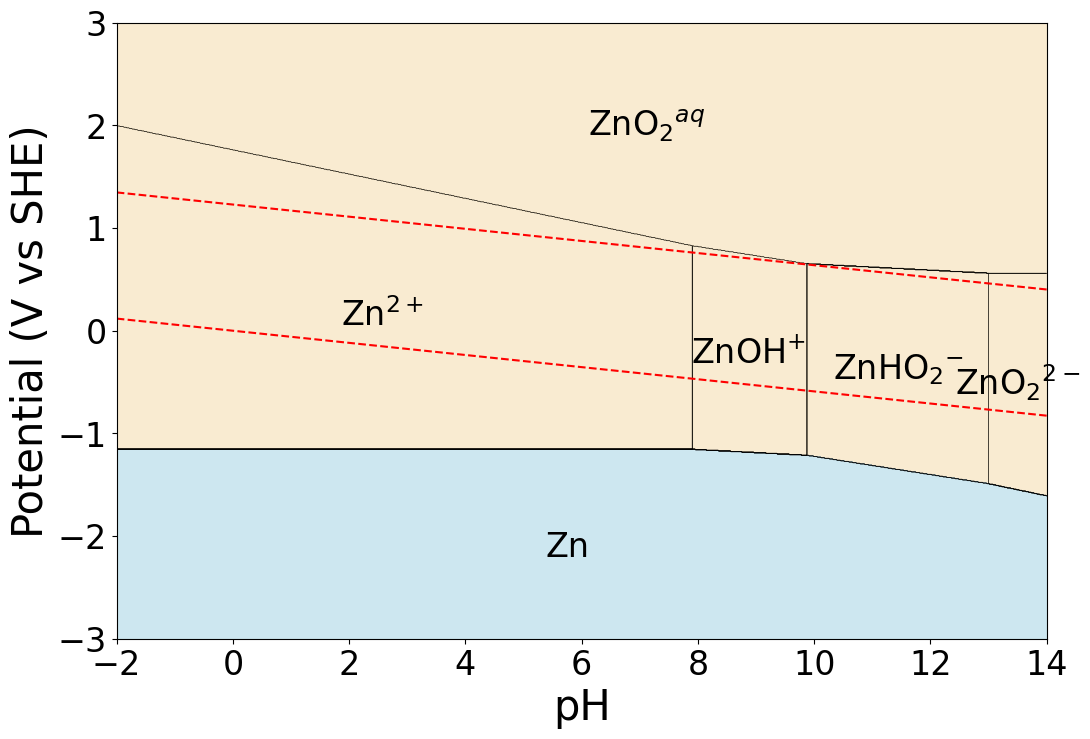

In [42]:
# Zn Pourbaix diagram
bias = -3.958 + 3.528
species_data = [
    {
        'name': 'Zn$^{2+}$',
        'formula_str': 'Zn',
        'phase': 'ion',
        'charge': +2,
        'Ef': -1.525 + bias
    },    
    {
        'name': 'ZnO$_2$$^{aq}$',
        'formula_str': 'ZnO2',
        'phase': 'ion',
        'charge': 0,
        'Ef': -2.921 + bias
    }, 
    {
        'name': 'ZnOH$^{+}$',
        'formula_str': 'ZnOH',
        'phase': 'ion',
        'charge': +1,
        'Ef': -3.518 + bias
    },     
    {
        'name': 'ZnO$_2$$^{2-}$',
        'formula_str': 'ZnO2',
        'phase': 'ion',
        'charge': -2,
        'Ef': -4.042 + bias
    }, 
    {
        'name': 'ZnHO$_2$$^{-}$',
        'formula_str': 'ZnHO2',
        'phase': 'ion',
        'charge': -1,
        'Ef': -4.810 + bias
    },

    # solids
    {
        'name': 'ZnO',
        'formula_str': 'ZnO',
        'phase': 'solid',
        'charge': 0,
        'Ef': -1.643*2
    },
    {
        'name': 'Zn',
        'formula_str': 'Zn',
        'phase': 'solid',
        'charge': 0,
        'Ef': 0
    }

    
]

# Note: MUST ensure all solid/ion compounds have stoichiometry of Ti as one, since we are simulating the solvation of one unit of Ti!

# Constants
F = 96485.33212  # Faraday's constant, C/mol
R = 8.314462618  # Gas constant, J/(mol·K)
T = 298.15       # Temperature, K

# Create a grid of pH and E values
pH_range = np.linspace(-2, 14, 1000)
E_range = np.linspace(-3, 3, 1000)
pH_grid, E_grid = np.meshgrid(pH_range, E_range)

# Function to parse chemical formulas
def parse_formula(formula):
    # Updated regex pattern to capture decimal numbers
    pattern = r'([A-Z][a-z]*)(\d*\.?\d*)'
    tokens = re.findall(pattern, formula)
    formula_dict = {}
    for (element, count) in tokens:
        if count == '':
            count = 1.0  # Default to 1.0 for elements without a count
        else:
            count = float(count)  # Convert to float to handle decimal numbers
        formula_dict[element] = formula_dict.get(element, 0) + count
    return formula_dict

# Parse the formulas
for species in species_data:
    if 'formula_str' in species:
        species['formula'] = parse_formula(species['formula_str'])
    else:
        species['formula'] = parse_formula(species['name'])

# Function to calculate Gibbs free energy for each species at each point
def calculate_gibbs_energy(species, pH_grid, E_grid):
    y = species['formula'].get('O', 0)
    z = species['formula'].get('H', 0)
    delta_Gf = species['Ef']  # in eV/fu
    delta_Gf_H2O = -2.46      # in eV/fu
    if species['phase'] == 'solid':
        n = 2 * y - z
        if n == 0:  # indicates that pure solid Ti has been input
            return np.zeros_like(pH_grid)
        E_standard = -(y * delta_Gf_H2O - delta_Gf) / n
        E_calc = E_standard - 0.0591 * pH_grid
    elif species['phase'] == 'ion':
        c = species['charge']
        n = 2 * y + c - z
        if n == 0:
            return None
        E_standard = -(y * delta_Gf_H2O - delta_Gf) / n
        log_conc = np.log10(1e-6)  # Assuming 10^-6 M concentration
        E_calc = E_standard + (0.0591 / n) * (log_conc - (2 * y - z) * pH_grid)
    else:
        return None
    # Calculate Gibbs free energy at each point
    delta_G = n * (E_calc - E_grid)  # in J/mol
    return delta_G

# Calculate Gibbs free energy for each species
delta_G_species = []
for species in species_data:
    delta_G = calculate_gibbs_energy(species, pH_grid, E_grid)
    if delta_G is not None:
        delta_G_species.append({
            'name': species['name'],
            'delta_G': delta_G
        })

# Determine the most stable species at each point
delta_G_values = np.array([s['delta_G'] for s in delta_G_species])
stable_indices = np.argmin(delta_G_values, axis=0)

# Initialize stable species array
stable_species = np.empty_like(pH_grid, dtype=object)

# Assign the most stable species to each point in the grid
for i in range(stable_indices.shape[0]):
    for j in range(stable_indices.shape[1]):
        min_index = stable_indices[i, j]
        stable_species[i, j] = delta_G_species[min_index]['name']

# Map species names to integers for coloring
species_names = [s['name'] for s in species_data]
species_to_int = {name: idx for idx, name in enumerate(species_names)}
stable_species_int = np.vectorize(species_to_int.get)(stable_species)

# Get all oxygen values to normalize
oxygen_values = [species['formula'].get('O', 0) for species in species_data if species['phase'] == 'solid']

# Normalize oxygen values for colormap
norm = mcolors.Normalize(vmin=min(oxygen_values), vmax=max(oxygen_values))
colormap = plt.cm.Greens  # Use the 'Greens' colormap for varying green shades

species_colors = []
for species in species_data:
    if species['phase'] == 'solid':
        species_colors.append('#ADD8E6')  # Light blue
    elif species['phase'] == 'ion':
        # Ionic compounds (beige)
        species_colors.append('#F5DEB3')  # Wheat (beige)
    else:
        # Default color for other types, if any
        species_colors.append('#D3D3D3')  # Light gray

# Create a color map from these specific colors
cmap = mcolors.ListedColormap(species_colors)

# Plotting the Pourbaix diagram
plt.figure(figsize=(12, 8))
plt.contourf(pH_grid, E_grid, stable_species_int, levels=np.arange(len(species_names) + 1) - 0.5, cmap=cmap, alpha=0.6)

# Plot boundaries between regions with different species
plt.contour(pH_grid, E_grid, stable_species_int, levels=np.arange(len(species_names) + 1) - 0.5, colors='black', linewidths=0.5)

# Find center of masses of stable regions
CM = []
for i in range(len(species_data)):
    try:
        val = i  # The integer value whose center of mass you want to find

        # Step 1: Create a mask where arr == val
        mask = (stable_indices == val)

        # Step 2: Get the indices where arr == val
        y_indices, x_indices = np.where(mask)

        # Step 3: Compute the mean x and y indices (no integer rounding)
        mean_x = np.mean(x_indices)
        mean_y = np.mean(y_indices)

        # Convert grid indices back to pH and E coordinates
        mean_pH = pH_range[int(mean_x)]
        mean_E = E_range[int(mean_y)]

        CM.append({
            'name': species_names[i],
            'mean_pH': mean_pH,
            'mean_E': mean_E
            })
    except:
        pass

# Plot the names at the centers of mass
for material in CM:
    name = material['name']
    mean_pH = material['mean_pH']
    mean_E = material['mean_E']
    plt.text(mean_pH, mean_E, name, ha='center', va='center', fontsize=24, color='black')

# Plot water stability lines
E_O2 = 1.229 - (0.0591) * pH_range  # O2/H2O line (assuming 4e- transfer)
E_H2 = 0 - (0.0591) * pH_range      # H+/H2 line (assuming 2e- transfer)
plt.plot(pH_range, E_O2, 'k--', label='O$_2$/H$_2$O', color='red')
plt.plot(pH_range, E_H2, 'k--', label='H$^+$/H$_2$', color='red')

# Set plot limits and labels
plt.xlim(-2, 14)
plt.ylim(-3, 3)
plt.xlabel('pH', fontsize=30)
plt.ylabel('Potential (V vs SHE)', fontsize=30)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)

# Create a custom legend for the plot
legend_elements = [Patch(facecolor=species_colors[i], label=species_names[i]) for i in range(len(species_names))]
# plt.legend(handles=legend_elements + [plt.Line2D([], [], linestyle='--', color='k', label='Water Stability Lines')], fontsize=10, loc='upper right')

plt.show()